# Matter-Antimatter asymmetries at the LHC

## Example program

Author: Dr Marco Gersabeck

Copyright &copy; 2020 The University of Manchester

### Overview
This example code follows the structure described in the lab script and depicted in the scheme below.

<img src="LabScheme.png" width="600">

### Configuration
The cell below imports all required Python modules. If you need more and add them there, make sure to execute this cell again before executing the cell requiring the new module.

In [1]:
import uproot
import numpy as np
import matplotlib.pylab as plt
import matplotlib.colors as colors
from scipy.optimize import curve_fit # https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html

### Input data
This opens input data files and assigns them to variables.

In [ ]:
events_sim = uproot.open('PhaseSpaceSimulation.root')
events_down = uproot.open('B2HHH_MagnetDown.root')
events_up = uproot.open('B2HHH_MagnetUp.root')

### Select data and calculate derived quantities
The following cell reads the input data. This is where all derived quantities (such as transverse momentum) should be calculated and where selection criteria are applied (such as the z component of the momentum being positive).

In [10]:
# Check what's in the tree. 
# Note that the simulation tree is called 'PhaseSpaceTree' and does not have the ProbPi/K variables filled.
print('Input data variables:')
print(events_up['DecayTree'].keys())

# These are the arrays to hold the data
pT = []
pX = []
pY = []
pZ = []

# A counter for bookkeeping
event_counter = 0

# If set to a value greater than 0, limits the number of events analysed
MAX_EVENTS = -1

# This outer loop is a technical loop of uproot over chunks of events
for data in events_sim[b'PhaseSpaceTree'].iterate([b'H*_P[XYZ]',b'H*_Charge']):
    # As Python can handle calculations with arrays, we can calculate derived quantities here
    pT_H1 = np.sqrt(data[b'H1_PX']**2+data[b'H1_PY']**2)
    pT_H2 = np.sqrt(data[b'H2_PX']**2+data[b'H2_PY']**2)
    pT_H3 = np.sqrt(data[b'H3_PX']**2+data[b'H3_PY']**2)

    # This loop will go over individual events
    for i in range(0,len(data[b'H1_PZ'])):
        event_counter += 1
        if 0 < MAX_EVENTS and MAX_EVENTS < event_counter: break
        if 0 == (event_counter % 100000): print('Read', event_counter, 'events')
        # Decide here which events to analyse
        if (data[b'H1_PZ'][i] > 0) and (data[b'H2_PZ'][i] > 0) and (data[b'H3_PZ'][i] > 0):
            # Fill arrays of events to be plotted and analysed further below
            # Adding values for all three hadrons to the same variable here
            pT.append(pT_H1[i])
            pT.append(pT_H2[i])
            pT.append(pT_H3[i])
            pX.append(data[b'H1_PX'][i])
            pX.append(data[b'H2_PX'][i])
            pX.append(data[b'H3_PX'][i])
            pY.append(data[b'H1_PY'][i])
            pY.append(data[b'H2_PY'][i])
            pY.append(data[b'H3_PY'][i])
            pZ.append(data[b'H1_PZ'][i])
            pZ.append(data[b'H2_PZ'][i])
            pZ.append(data[b'H3_PZ'][i])
    
print('Read {:d} events'.format(event_counter))

Input data variables:
[b'B_FlightDistance', b'B_VertexChi2', b'H1_PX', b'H1_PY', b'H1_PZ', b'H1_ProbK', b'H1_ProbPi', b'H1_Charge', b'H1_IPChi2', b'H1_isMuon', b'H2_PX', b'H2_PY', b'H2_PZ', b'H2_ProbK', b'H2_ProbPi', b'H2_Charge', b'H2_IPChi2', b'H2_isMuon', b'H3_PX', b'H3_PY', b'H3_PZ', b'H3_ProbK', b'H3_ProbPi', b'H3_Charge', b'H3_IPChi2', b'H3_isMuon']
Read 50000 events


### Visualise data
The cell below produces histograms of the data contained in the arrays that were filled in the cell above.

Plotting 1D histogram
Plotting 2D histogram


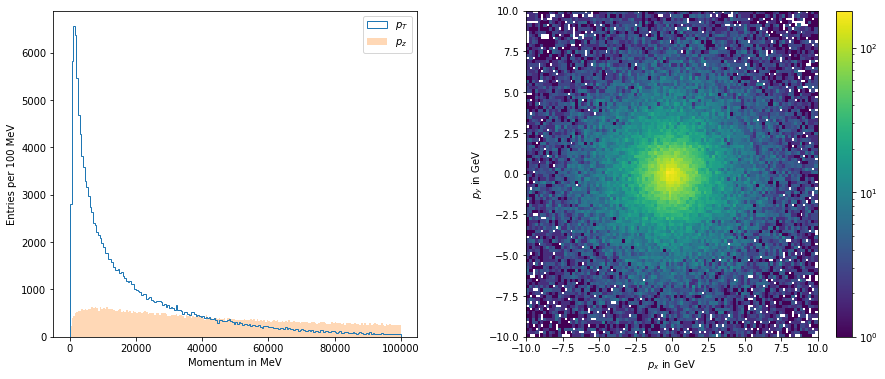

In [8]:
# Plot some histograms -- NOTE: this can take several minutes

# This line produces two plots side-by-side. 
# It's still useful just for one plot as you can set the size and get the fig,ax objects
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
fig.subplots_adjust(wspace=0.3) # increase horizontal space between plots

# This plots two 1D-histograms.
# The color is changed automatically, the styles are set by hand
# keep hold of the pT histogram data for fitting later
print('Plotting 1D histogram')
values_pT,bins_pT,patches_pT = ax[0].hist(pT, bins = 200, range = [0, 100000],histtype='step',label='$p_{T}$')
ax[0].hist(pZ, bins = 200, range = [0, 100000],histtype='stepfilled',alpha=0.3,label='$p_{z}$')
ax[0].set_xlabel('Momentum in MeV')
ax[0].set_ylabel('Entries per 100 MeV')
ax[0].legend()
plt.savefig('pTpZ.pdf')

# This plots a 2D-histogram with values converted to GeV and with a logarithmic colour scale
print('Plotting 2D histogram')
h2d = ax[1].hist2d(np.true_divide(pX,1000), np.divide(pY,1000), bins = [100,100], range = [[-10,10],[-10,10]],norm=colors.LogNorm())
ax[1].set_xlabel('$p_{x}$ in GeV')
ax[1].set_ylabel('$p_{y}$ in GeV')
fig.colorbar(h2d[3],ax=ax[1]) # let's add the colour scale
plt.savefig('pXpY.pdf')

### Analyse data
The cell below fits a function to the histogram data for transverse momentum. While the different plotting style requires some manipulation of the data points, no new histogram is created from the input data but rather the histogram produced in the previous cell is used.

Fit results
Par 1: 236.056942 +/- 14.777946
Par 2: 3335.764377 +/- 68.351726
Par 3: 0.000072 +/- 0.000002


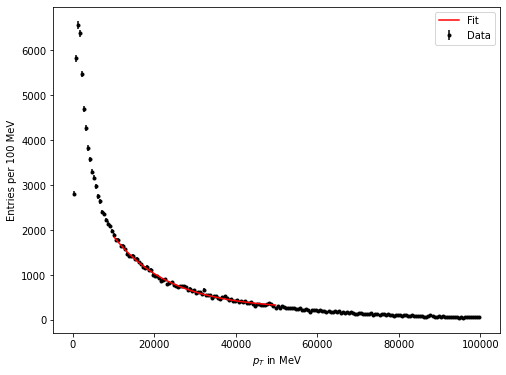

In [9]:
# decaying exponential function
def exponential(x, norm, decay):
    return np.array( norm * np.exp(-x*decay) )

# constant function
def constant(x, norm):
    return np.array( norm )

# fit function combining two individual functions
def fit_function(x, normC, normE, decay):
    return np.array( constant(x, normC) + exponential(x, normE, decay) )
    
# determine bin centres
bin_centres_pT = [(a+b)/2 for a,b in zip(bins_pT[0:-1],bins_pT[1:]) ] # uses simultaneous loop over two arrays

# reduce range to fit only part of curve
bin_centres_red_pT = [] 
values_red_pT = []
for c,v in zip(bin_centres_pT,values_pT):
    if c < 10000 or c > 50000: continue
    bin_centres_red_pT.append(c)
    values_red_pT.append(v)

# execute the fit with starting values 5000 and 10^-4
coeff_pT_fit,cov_pT_fit = curve_fit(fit_function,bin_centres_red_pT,values_red_pT,p0=[100,5000,1e-4]) # fit
perr_pT_fit = np.sqrt(np.diag(cov_pT_fit)) # extract errors from covarianve matrix

# output fit results
print('Fit results')
parcount = 0
for p,e in zip(coeff_pT_fit,perr_pT_fit):
    parcount += 1
    print('Par {:d}: {:f} +/- {:f}'.format(parcount,p,e))

# plot results
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))

# plot the data, this time as dots with error bars (sqrt(N) errors)
ax.errorbar(bin_centres_pT,values_pT,yerr=np.sqrt(values_pT),linestyle='',marker='.',
            markerfacecolor='k',markeredgecolor='k',ecolor='k',label='Data')

# plot the fit: create x values, then calculate the corresponding y values and plot
x_fit = np.linspace(bin_centres_red_pT[0],bin_centres_red_pT[-1],100)
y_fit = fit_function(x_fit,coeff_pT_fit[0],coeff_pT_fit[1],coeff_pT_fit[2])
ax.plot(x_fit,y_fit,label='Fit',color='r',zorder=10) # zorder makes sure the fit line is on top

# plot decoration
ax.legend()
ax.set_xlabel('$p_{T}$ in MeV')
ax.set_ylabel('Entries per 100 MeV')
plt.savefig('pTfit.pdf')